# Model Analysis

**We will use an LSTM-based RNN for multiclass classification.**

**The labels will be the star ratings.**

**We select a neural network because we want to capture the relationship between reviews and star ratings, we are not primarily concerned with understanding the nature of this relationship, and we have a very large amount of data.**

**We select an RNN because the data can be understood as time series.**

**We select an LSTM due to their ability to capture both long and short term temporal relationships, including non-sequential or disjoined relationships, which are common in human language.**

In [1]:
import os
os.chdir('/home/clementejasonfortuna/workspace/705.603Portfolio/Multimodal-Analysis/analysis')
os.environ['TF_USE_LEGACY_KERAS'] = '1'

from collections import deque
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from multiprocessing import Pool
from itertools import repeat
import time
import pickle

from Helpers import preprocess, tokentext2seqs

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import contractions
import string

import tensorrt
from tensorflow.keras.utils import pad_sequences
import tensorflow.keras.layers as tfkl
import tensorflow.keras as tfk
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K



2024-04-21 11:25:42.856152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 11:25:43.669131: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pd.set_option('display.max_columns', None)  # None or 1000
pd.set_option('display.max_rows', 10)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

**Ingest the data**

In [3]:
df = pd.read_csv('../data/amazon_movie_reviews.csv')

/tmp/ipykernel_167559/1706385969.py:1: DtypeWarning: Columns (18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/amazon_movie_reviews.csv')


## First data preprocessing

**The helper for normalizing/stemming/tokenizing:**

In [4]:
def get_proccorpus(dfproc):
    """
    Get a normalized, stemmed, tokenized form of a corpus of text.
    
    parameters:
    corpus (list of str): The text corpus
    
    returns:
    tokentext (list of [str]): The tokenized corpus
    proctext (list of str): The tokenized corpus with word re-joined
    ratings (list of float): The star ratings
    """
    corpus = dfproc['text'].to_list()
    ratings = dfproc['rating'].to_list()
    # corpus = corpus.to_list()
    with Pool(14) as pool:  # see helper
        result = pool.starmap(preprocess, zip(corpus, ratings))
    
    df = pd.DataFrame(result, columns = ['tokentext', 'proctext', 'rating'])
    tokentext = df['tokentext'].to_list()
    proctext = df['proctext'].to_list()
    ratings = df['rating'].to_list()
    
    return (tokentext, proctext, ratings)
        

**The helper word2vec model training/encoding:**

In [5]:
def encode(tokenproctext, w2vsz):
    """
    Encode a tokenized corpus according to the Word2Vec method.
    
    parameters:
    tokenproctext (tuple of list): The tokenized corpus both in original and
            word-rejoined form
    w2vsz (int): The embedding feature space size
    """
    proccorpus = tokenproctext[0]  # needs processed tokens
    word2vec_model = Word2Vec(proccorpus, vector_size=w2vsz, min_count=1,
                              workers=14)

    return word2vec_model

**The helper for token to index conversion:**

In [6]:
def get_ttxts2seqs(ttxt, tokshash, inputsz):
    """
    Convert tokens to their indices in the word2vec model.
    
    parameters:
    ttxt (list of [str]): The tokens
    tokshash (dict of int): The word2vec indices of each token
    inputsz (int): The size limit of the input vectors
    
    returns:
    result (iterable of [int]): The indices of the tokens
    """
    with Pool(14) as pool:  # see helper
        result = pool.starmap(tokentext2seqs, zip(ttxt, repeat(tokshash), repeat(inputsz)))
    
    return result

**The data preprocessing pipeline:**

In [7]:
def get_data(df, inputsz, w2vsz):
    """
    Prepare the dataframe and embedding weights for machine learning.
    
    parameters:
    df (dataframe): The ingested dataframe
    inputsz (int): The size limit of the input vectors
    w2vsz (int): The embedding feature space size
    
    returns:
    embed_model (Word2Vec model): The trained word2vec model
    dfproc (dataframe): The processed dataframe
    ntoks (int): The total number of unique tokens
    tokshash (dict): The mapping from tokens to their word2vec indices
    """
    df2 = df.drop_duplicates(subset=['text'])
    dffil = df2.loc[df2['text'].notna(), ['rating', 'text']]
    
    stime = time.time()
    tokenproctext = get_proccorpus(dffil[:])
    print('tokenization done: {}'.format(time.time() - stime))
    
    stime = time.time()
    embed_model = encode(tokenproctext, w2vsz)
    print('embedding model done: {}'.format(time.time() - stime))
    
    ttxt = tokenproctext[0]
    ratings = tokenproctext[2]
    alltoks = list(embed_model.wv.key_to_index.keys())
    # O(N) lookup time for dict.  Critical to speeding up get_ttxts2seqs()
    tokshash = dict(zip(alltoks, range(0, len(alltoks))))
    
    stime = time.time()
    seqs = get_ttxts2seqs(ttxt[:], tokshash, inputsz)
    print('sequences done: {}'.format(time.time() - stime))
    
    dfproc = pd.DataFrame({'seqs': seqs, 'ratings': ratings})
    
    dfproc = pd.get_dummies(data=dfproc, columns=['ratings'])
    ratcols = [col for col in dfproc.columns if 'ratings' in col]   
    dfproc[ratcols] = dfproc[ratcols].replace({True: 1, False: 0})
    dfproc['ratings'] = dfproc[ratcols].values.tolist()
    dfproc['ratings'] = dfproc['ratings'].to_numpy()
    dfproc = dfproc.drop(ratcols, axis=1)
    
    ntoks = len(alltoks)

    return embed_model, dfproc, ntoks, tokshash

In [8]:
inputsz = 100
w2vsz = 100
embed_model, dfproc, ntoks, tokshash = get_data(df, inputsz, w2vsz)

tokenization done: 73.94380187988281
embedding model done: 44.34585762023926
sequences done: 28.304012298583984


In [9]:
with open('../models/tokshash.bin', mode='wb') as f:
    pickle.dump(tokshash, f)
    
with open('../models/dfproc.bin', mode='wb') as f:
    pickle.dump(dfproc, f)

In [10]:
dfproc

,seqs,ratings
0,"[150, 378, 140, 10, 616, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1]"
1,"[4441, 3, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1]"
2,"[15135, 18487, 15, 1037, 312, 1057, 1460, 810, 3995, 919, 1042, 22, 2090, 2233, 1533, 251, 668, 345, 316, 1846, 312, 3009, 218, 3, 24, 14, 24, 100, 75, 7, 2003, 125, 3636, 451, 0, 547, 346, 129, 7, 56046, 5370, 76, 251, 145353, 75, 33, 592, 1426, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0]"
3,"[1316, 15, 35224, 3771, 593, 3894, 2958, 33, 368, 247, 2484, 907, 3, 305, 40, 1225, 1439, 120, 232, 827, 678, 353, 345, 4020, 10, 158, 1454, 892, 115, 521, 20, 261, 1966, 889, 15, 4020, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0]"
4,"[95, 116, 41, 0, 705, 678, 739, 1286, 228, 332, 836, 34, 138, 1596, 340, 61, 218, 1202, 2796, 96, 690, 3814, 1584, 21, 148, 1210, 296, 4, 158, 88, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1]"
...,...,...
828691,"[82, 118, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1]"
828692,"[27, 350, 1051, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1]"
828693,"[6, 442, 76, 6, 15, 66, 96, 1677, 151, 257, 72, 476, 8011, 247, 1980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0]"
828694,"[2, 551, 153, 46, 4, 10192, 105, 112, 451, 2318, 9, 106, 38, 410, 451, 66, 1225, 221, 2318, 507, 78, 1282, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0]"


**Now create the train/val/test split:**

In [11]:
X = np.stack(np.array(dfproc['seqs']))
Y = np.stack(np.array(dfproc['ratings']))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                    test_size=0.1, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                    test_size=1/9, stratify=Y_train)

## Now model creation and training definition

**Define the LSTM model:**

**To speed up learning we load the word2vec embeddings rather than using randomly initialized embedding weights. To reduce runtime we use a single LSTM and dense layer. To improve generalized performance, we use dropout.**

**The hyperparameters will be tuned later.**

In [12]:
def LSTM_model(ntoks, w2vsz, embed_mat, lstmunits, lstmdo,
               rdo, fcunits, fcd):
    """
    The LSTM-based RNN model.
    
    parameters:
    ntoks (int): The total number of unique tokens
    w2vsz (int): The embedding feature space size
    embed_mat (numpy array): The embedding weight matrix from word2vec
    lstmunits (int): The number of LSTM neurons
    lstmdo (float): The input LSTM dropout
    rdo (float): The recurrent LSTM dropout
    fcunits (int): The number of dense neurons
    fcd (float): The dense dropout
    
    returns:
    model (tensorflow model): The LSTM-based RNN model.
    """
    model = tfk.Sequential()

    input_dat = tfkl.Embedding(ntoks, w2vsz)
    input_dat.build(input_shape=(1,))
    # initialize with the word2vec embedding weights
    input_dat.set_weights([embed_mat])
    
    model.add(input_dat)
    model.add(tfkl.LSTM(lstmunits, dropout=lstmdo, recurrent_dropout=rdo))
    model.add(tfkl.Dense(fcunits, activation='relu'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(fcd))
    model.add(tfkl.Dense(units = 5, activation = 'softmax'))
    
    return model

**A custom callback to facilitate tiebreaking for model saving, based on summing scaled training and validation accuracies:**

In [13]:
class CombineCallback(tfk.callbacks.Callback):
    """
    A custom callback to facilitate tiebreaking for model saving, based on summing scaled training and validation accuracies
    """
    def __init__(self, **kargs):
        super(CombineCallback, self).__init__(**kargs)

    def on_epoch_end(self, epoch, logs={}):
        logs['combine_accuracy'] = 0.999 * logs['val_accuracy'] + 0.001 * logs['accuracy']

**Accuracy is one of the metrics.  We select it because it provides an intuitive measure for whether or not the model is learning.  Specifically, the result must be compared to the proportion of the most common label.  In *expoloratory_data_analysis.ipynb,* this was %60.3 for the 5 star rating.**

**The training/evaluation pipeline:**

In [14]:
def train_eval_mod(X_train, X_vt, Y_train, Y_vt, epochs, batch_size, ntoks,
                   w2vsz, embed_mat, lstmunits, lstmdo, rdo, fcunits, fcd):
    """
    Train the model and make a final prediction.
    
    Saves the best performing model.
    
    parameters:
    X_train (np.array): The training data
    X_vt (np.array): The validation/testing data
    Y_train (np.array): The training labels
    Y_vt (np.array): The validation/testing labels
    epochs (int): The number of training passes through the data
    batch_size (int): The number of data points required for each weight update
    ntoks (int): The total number of unique tokens
    w2vsz (int): The embedding feature space size
    embed_mat (numpy array): The embedding weight matrix from word2vec
    lstmunits (int): The number of LSTM neurons
    lstmdo (float): The input LSTM dropout
    rdo (float): The recurrent LSTM dropout
    fcunits (int): The number of dense neurons
    fcd (float): The dense dropout
    
    returns:
    history (tensorflow History): The record of training and validation metrics
    y_preds (np.array): The prediction for the validation/testing data
    """
    model = LSTM_model(ntoks, w2vsz, embed_mat, lstmunits, lstmdo,
               rdo, fcunits, fcd)
    opt = tfk.optimizers.legacy.Adam()
    model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    model.summary()
    mod_callback = ModelCheckpoint(filepath = '../models/text_model.h5',
                                  save_weights_only = False,
                                  monitor = 'combine_accuracy',
                                  mode = 'max',
                                  save_best_only = True)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                       validation_data=(X_vt, Y_vt),
                       callbacks = [CombineCallback(), mod_callback])
    model = tfk.models.\
            load_model('../models/text_model.h5')
    y_preds = model.predict(X_vt)
    
    return history, y_preds


**Another performance metric, which we call *proximalperf*.  See the docstring for discussion/description:**

In [15]:
def get_proximalperf(Y_vt, y_preds):
    """
    Compute proximalperf.
    
    Assigns a value of 1 for each correct label, and a value (5-abs(diff))/nclasses
    for each incorrect label. For example, if *y_truth=5* and *y_pred=2*,
    then the value will be 2/5.
    
    This allows some lenience if scores were only a single star rating off.
    This is important because there is inherent subjectivity and error in the
    star ratings versus the text.
    
    parameters:
    Y_vt (np.array): The validation/testing labels
    y_preds (np.array): The prediction for the validation/testing data
    
    returns:
    proximalperf (float): The proximalperf score
    """
    truidxs = np.argwhere(Y_vt > 0)[:, 1]
    prdidxs = np.argmax(y_preds, axis=1)
    tot = (5 - np.abs(truidxs - prdidxs)) / y_preds.shape[1]
    proximalperf =  np.sum(tot)
    proximalperf /= y_preds.shape[0]
    
    return proximalperf


## Now tune hyperparameters

**We will explore 64 vs 128 neurons in each layer/cell, and dropout vs no dropout.**

In [16]:
def tune_model(X_train, X_val, Y_train, Y_val, ntoks,
               inputsz, w2vsz, embed_model):
    X_train = X_train[:50000, :]
    Y_train = Y_train[:50000, :]
    X_vt = X_val[:5000, :]
    Y_vt = Y_val[:5000, :]

    epochs = 10
    batch_size = 64
    embed_mat = embed_model.wv.vectors
    
    histories = []
    proxperfs = []
    for units in [64, 128]:
        for do in [0, 0.5]:
            lstmunits = units
            fcunits = units
            lstmdo = do
            rdo = do
            fcd = do
            history, y_preds = train_eval_mod(X_train, X_vt, Y_train, Y_vt, epochs,
                    batch_size, ntoks, w2vsz, embed_mat, lstmunits, lstmdo,
                    rdo, fcunits, fcd)
            histories.append(history)
            proxperf = get_proximalperf(Y_vt, y_preds)
            proxperfs.append(proxperf)
    
    return histories, proxperfs
    

In [17]:
histories, proxperfs = tune_model(X_train, X_val, Y_train, Y_val, ntoks,
               inputsz, w2vsz, embed_model)

2024-04-21 11:28:59.103354: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 11:28:59.145729: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 11:28:59.145882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         31067500  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                        

2024-04-21 11:29:16.282375: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1713713356.695490  167876 service.cc:145] XLA service 0x7771ec0f0640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713713356.695634  167876 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 Super, Compute Capability 7.5
2024-04-21 11:29:16.711415: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713713356.792736  167876 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 [==============================] - ETA: 0s - loss: 1.0857 - accuracy: 0.6187

/home/clementejasonfortuna/anaconda3/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


782/782 [==============================] - 57s 53ms/step - loss: 1.0857 - accuracy: 0.6187 - val_loss: 0.9154 - val_accuracy: 0.6418 - combine_accuracy: 0.6418
Epoch 2/10
782/782 [==============================] - 14s 18ms/step - loss: 0.8749 - accuracy: 0.6626 - val_loss: 0.8707 - val_accuracy: 0.6590 - combine_accuracy: 0.6590
Epoch 3/10
782/782 [==============================] - 10s 13ms/step - loss: 0.7923 - accuracy: 0.6960 - val_loss: 0.8831 - val_accuracy: 0.6588 - combine_accuracy: 0.6588
Epoch 4/10
782/782 [==============================] - 10s 13ms/step - loss: 0.6898 - accuracy: 0.7391 - val_loss: 0.9738 - val_accuracy: 0.6596 - combine_accuracy: 0.6597
Epoch 5/10
782/782 [==============================] - 9s 11ms/step - loss: 0.6060 - accuracy: 0.7735 - val_loss: 1.0881 - val_accuracy: 0.6434 - combine_accuracy: 0.6435
Epoch 6/10
782/782 [==============================] - 8s 10ms/step - loss: 0.5392 - accuracy: 0.8018 - val_loss: 1.1894 - val_accuracy: 0.6180 - combine_accu

units=64, do=0.0, proximalperf=0.8907200000000001
units=64, do=0.5, proximalperf=0.8952400000000001
units=128, do=0.0, proximalperf=0.8914799999999999
units=128, do=0.5, proximalperf=0.8972400000000001


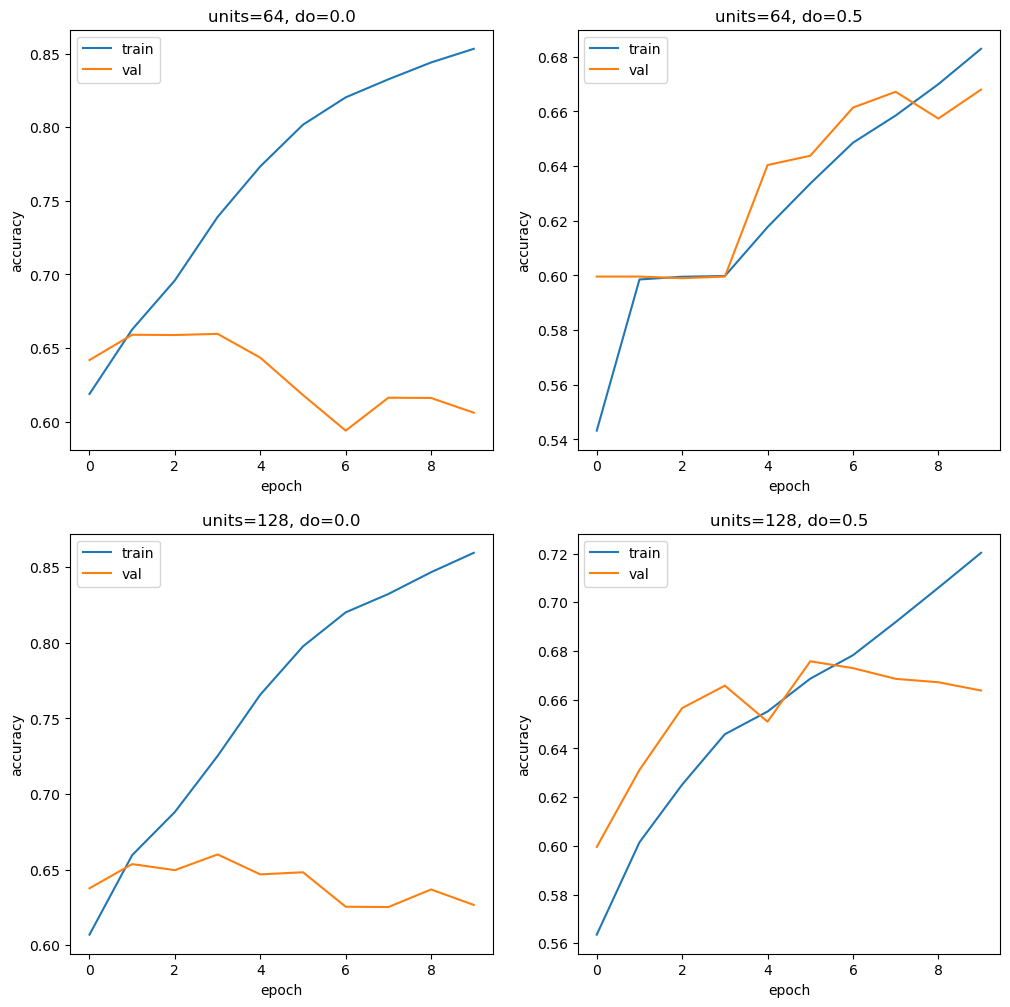

In [18]:
def plot_tuning(histories, proxperfs):
    nrow = 2
    ncol = 2
    titles = ['units=64, do=0.0', 'units=64, do=0.5', 'units=128, do=0.0', 'units=128, do=0.5']
    fig, ax = plt.subplots(nrow, ncol, figsize=(12, 12))
    ctr = 0
    for ir in range(0, nrow):
        for ic in range(0, ncol):
            print('{}, proximalperf={}'.format(titles[ctr], proxperfs[ctr]))
            ax[ir, ic].plot(histories[ctr].history['accuracy'])
            ax[ir, ic].plot(histories[ctr].history['val_accuracy'])
            ax[ir, ic].set_title(titles[ctr])
            ax[ir, ic].set_ylabel('accuracy')
            ax[ir, ic].set_xlabel('epoch')
            ax[ir, ic].legend(['train', 'val'], loc='upper left')
                                        
            ctr += 1
    plt.show()
            
plot_tuning(histories, proxperfs)

**As expected the models without dropout demonstrated overfitting in the plots.**

**Between the *dropout=0.5* models in the *proximalperf* output, the 128 neuron model showed the best performance.  This means that while accuracy was comparable with the 64 neuron model, the 128 neuron model was less erroneous in the magnitude of difference in star predictions (i.e. being only 1 star off, rather than 2 stars off).**

**Hence we will select *dropout=0.5* and 128 neurons for the final model.**

In [19]:
def finalize_model(X_train, X_test, Y_train, Y_test, ntoks,
               inputsz, w2vsz, embed_model):
    X_train = X_train
    Y_train = Y_train
    X_vt = X_test
    Y_vt = Y_test

    epochs = 5
    batch_size = 64
    embed_mat = embed_model.wv.vectors
    lstmunits = 128
    lstmdo = 0.5
    rdo = 0.5
    fcunits = 128
    fcd = 0.5

    history, y_preds = train_eval_mod(X_train, X_vt, Y_train, Y_vt, epochs,
            batch_size, ntoks, w2vsz, embed_mat, lstmunits, lstmdo,
            rdo, fcunits, fcd)
    proxperf = get_proximalperf(Y_vt, y_preds)
    
    return history, proxperf
    

In [20]:
history, proxperf = finalize_model(X_train, X_test, Y_train, Y_test, ntoks,
               inputsz, w2vsz, embed_model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         31067500  
                                                                 
 lstm_4 (LSTM)               (None, 128)               117248    
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                      

0.9059008084952335


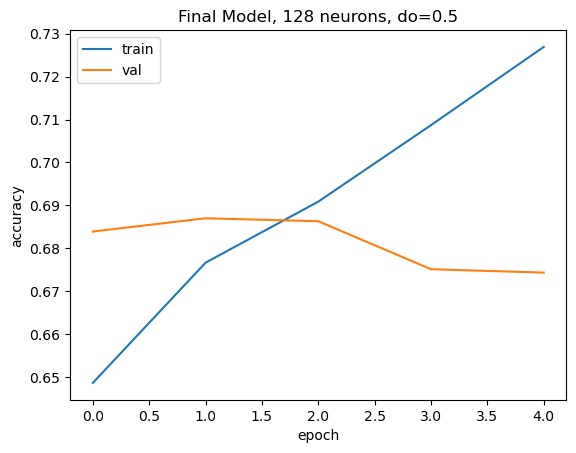

In [21]:
print(proxperf)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Final Model, 128 neurons, do=0.5')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


**Curiously, there seems to be some overfitting in spite of dropout=0.5 in place at the LSTM input, LSTM recurrent state, and the dense layer.  Nonetheless, the validation accuracy remains in range with the hyperparameter tuning results (approx %68) and exceeds the trivial result (%60.3).  Additionally, the *proximalperf* result is the highest, which is what we expected after using a much larger training set and more epochs.**